In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data

### Helper functions

In [24]:
def loadData(file):
    data = pd.read_csv(file)
    print('Raw shape: ',data.shape)
    data['Date'] = pd.to_datetime(data.Date)
    print('Days: ',len(set(data.Date)))
    return data

In [25]:
def getTimeSeries(df):
    table = pd.pivot_table(df, values='vehicle_count', index=['Date','Hour'],
                    columns=['DOLocationID'], aggfunc=np.sum, fill_value=0)
    return table

In [26]:
class autoencoder(nn.Module):
    def __init__(self,inputD,encoding_dim):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential()
        
        self.encoder.add_module("enc_0", nn.Linear(inputD,encoding_dim[0]))
        self.encoder.add_module("relu_0", nn.ReLU())
          
        for l in range(1,len(encoding_dim)):
            self.encoder.add_module("enc_"+str(l), nn.Linear(encoding_dim[l-1],encoding_dim[l]))
            self.encoder.add_module("encBn_"+str(l),nn.BatchNorm1d(encoding_dim[l]))
            self.encoder.add_module("encrelu_"+str(l), nn.ReLU())
                                    
        self.decoder = nn.Sequential()
        
        for l in range(len(encoding_dim)-1,0,-1):
            self.decoder.add_module("dec_"+str(l), nn.Linear(encoding_dim[l],encoding_dim[l-1]))
            self.decoder.add_module("decBn_"+str(l),nn.BatchNorm1d(encoding_dim[l-1]))
            self.decoder.add_module("decrelu_"+str(l), nn.ReLU())
            
        self.decoder.add_module("dec_0", nn.Linear(encoding_dim[0],inputD))
        self.decoder.add_module("decrelu_0", nn.Sigmoid())
        
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def init_weights(self,m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def representation(self, x):
        x = self.encoder(x)
        return x

In [27]:
def gridSearchAutoEncoderDim(matrix, encoding_dim, components):
    rmse = []
    learning_rate=0.0001
    batch_size = 100
    num_epochs = 50
    for n in component:
        print(n)
        encodingDim = encoding_dim + [n]
        matrixtensor = torch.tensor(matrix).float()

        input_dim = matrix.shape[1]
        model = autoencoder(input_dim,encodingDim).cuda()

        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

        data_tensor = torch.utils.data.TensorDataset(matrixtensor, matrixtensor) 
        dataloader = torch.utils.data.DataLoader(dataset = data_tensor, batch_size = batch_size, shuffle = True)

        for epoch in range(num_epochs):
            for data in dataloader:
                X, _ = data
                X = X.cuda()
                # ===================forward=====================
                output = model(X)
                loss = criterion(output, X)
                MSE_loss = nn.MSELoss()(output, X)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # ===================log========================
    #         print('epoch [{}/{}], loss:{:.4f}, MSE_loss:{:.4f}'
    #             .format(epoch + 1, num_epochs, loss.item(), MSE_loss.item()))   

        with torch.no_grad():
            reconMatrixAE = model(matrixtensor.cuda()).cpu().numpy()
        reconCostAE = np.mean(np.power(reconMatrixAE - matrix,2))
        reconCostAE = np.power(reconCostAE,0.5)
        rmse.append(reconCostAE)
        print(reconCostAE)

    
    plt.plot(component,rmse)

#### preparing Data

In [28]:
file = '/home/urwa/Documents/Projects/NYU Remote/project/JfkVehiceByHour.csv'

In [29]:
dataDf = loadData(file)

Raw shape:  (4520160, 4)
Days:  730


In [30]:
dataDf = getTimeSeries(dataDf)

In [9]:
matrix = dataDf.values

In [10]:
#min max normalization
for i in range(matrix.shape[1]):
    matrix[:, i] = (matrix[:, i] - matrix[:, i].min()) / (matrix[:, i].max() - matrix[:, i].min())

In [11]:
matrix.shape

(17520, 258)

#### Selecting representation dimensions

In [12]:
matrix.mean()

0.00020972708930657322

5
0.012939884077540247
10
0.012069447879419697
15
0.011794802736624989
20
0.011073393135041666
25
0.01049915995159567
30
0.010524629193531877
35
0.012087254167287665
40
0.010535476802746947
45
0.010613046199303413


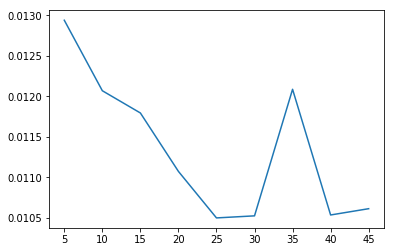

In [13]:
component = list(range(5,50,5))
encoding_dim = [100]
gridSearchAutoEncoderDim(matrix, encoding_dim, component)

#### Geting 10 dim representation space

In [14]:
learning_rate=0.0001
batch_size = 100
num_epochs = 100
encodingDim = [100,10]
matrixtensor = torch.tensor(matrix).float()

input_dim = matrix.shape[1]
model = autoencoder(input_dim,encodingDim).cuda()

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

data_tensor = torch.utils.data.TensorDataset(matrixtensor, matrixtensor) 
dataloader = torch.utils.data.DataLoader(dataset = data_tensor, batch_size = batch_size, shuffle = True)

for epoch in range(num_epochs):
    for data in dataloader:
        X, _ = data
        X = X.cuda()
        # ===================forward=====================
        output = model(X)
        loss = criterion(output, X)
        MSE_loss = nn.MSELoss()(output, X)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
#         print('epoch [{}/{}], loss:{:.4f}, MSE_loss:{:.4f}'
#             .format(epoch + 1, num_epochs, loss.item(), MSE_loss.item()))   


In [17]:
with torch.no_grad():
    reconMatrixAE = model.representation(matrixtensor.cuda()).cpu().numpy()
reconMatrixAE.shape

(17520, 10)

In [31]:
reducedDict = {str(i+1):reconMatrixAE[:,i] for i in range(reconMatrixAE.shape[1])}
reducedDf = pd.DataFrame(reducedDict)
reducedDf.index = dataDf.index

In [32]:
reducedDf.shape

(17520, 10)

In [33]:
reducedDf.head()

1         2        3    4    5         6         7  \
Date       Hour                                                              
2017-01-01 0     0.051075  0.037509  0.01015  0.0  0.0  0.154281  0.253439   
           1     0.051075  0.037509  0.01015  0.0  0.0  0.154281  0.253439   
           2     0.051075  0.037509  0.01015  0.0  0.0  0.154281  0.253439   
           3     0.051075  0.037509  0.01015  0.0  0.0  0.154281  0.253439   
           4     0.051075  0.037509  0.01015  0.0  0.0  0.154281  0.253439   

                        8         9        10  
Date       Hour                                
2017-01-01 0     0.156318  0.020118  0.269708  
           1     0.156318  0.020118  0.269708  
           2     0.156318  0.020118  0.269708  
           3     0.156318  0.020118  0.269708  
           4     0.156318  0.020118  0.269708

#### saving results

In [34]:
reducedDf.to_csv('AE_features.csv')